**Data Analysis and Model Building of Titanic Data Set**

This notebook sets out to analyze the Titanic Dataset from Kaggle with the objective to build a suitable Machine Learning Model to predict the Survival of passengers from unseen data.

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

**Upload Data**

In [50]:
df = pd.read_csv('train.csv')

In [140]:
kaggle_test = pd.read_csv('test.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Exploratory Data Analysis**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data contains significant null values in 3 columns. A heatmap can show the general distribution of null values throughout the dataset and can lead to a possible solution.

<AxesSubplot:>

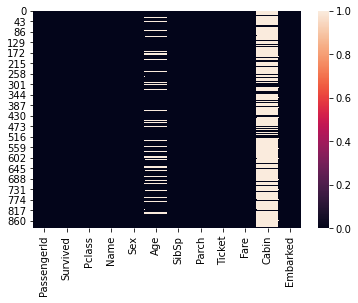

In [22]:
sns.heatmap(df.isnull())

Let's plot the distribution of numerical columns and assess correlations with Survivability.

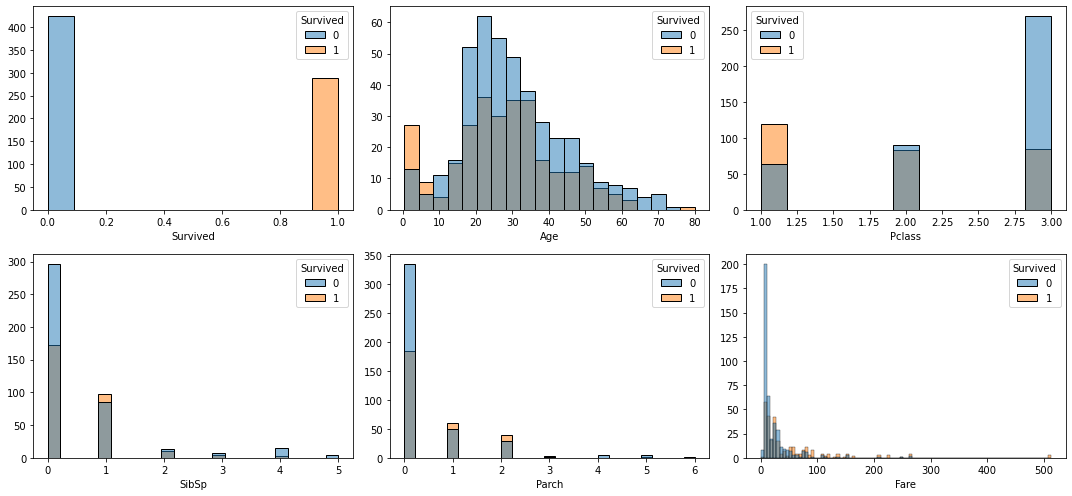

In [19]:
plt.figure(figsize=(15,7))
for i, col in enumerate(df[['Survived','Age','Pclass','SibSp','Parch','Fare']]):
  plt.subplot(2,3,i+1)
  sns.histplot(data=df, x=col, hue='Survived')
  plt.ylabel('')
  plt.tight_layout()

<AxesSubplot:>

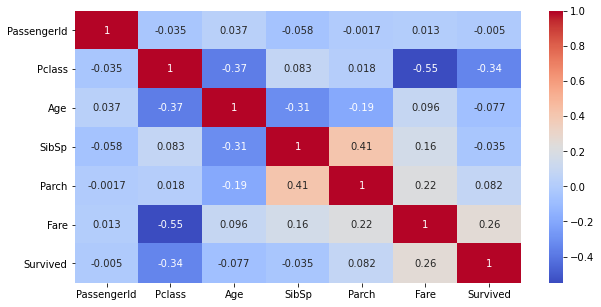

In [24]:
correlation = df[['PassengerId','Pclass','Age','SibSp','Parch','Fare','Survived']].corr()

plt.figure(figsize=(10,5))
sns.heatmap(correlation, annot=correlation, cmap='coolwarm')

Check categorical variables, assess Survival rate.

<AxesSubplot:xlabel='Sex', ylabel='count'>

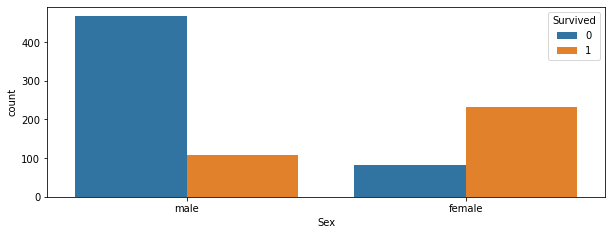

In [28]:
plt.figure(figsize=(10,3.5))
sns.countplot(data=df, x='Sex', hue='Survived')

Text(0, 0.5, 'sex')

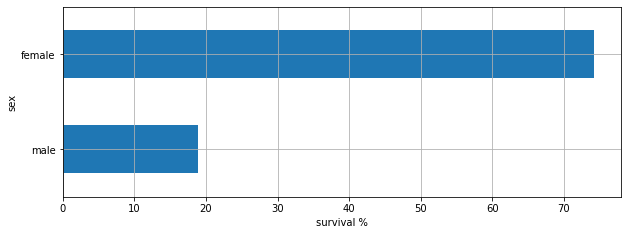

In [29]:
survival_rate_by_sex = df.groupby(by='Sex').sum()['Survived']*100/df.groupby(by='Sex').count()['Survived']

plt.figure(figsize=(10,3.5))
survival_rate_by_sex.sort_values(ascending=True).plot(kind='barh')
plt.grid(True)
plt.xlabel('survival %')
plt.ylabel('sex')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

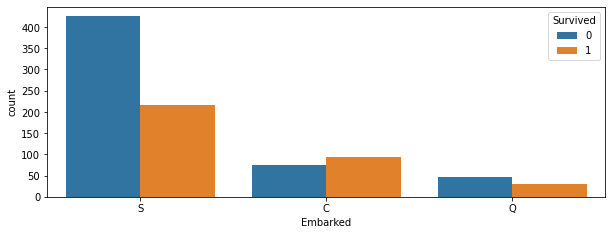

In [30]:
plt.figure(figsize=(10,3.5))
sns.countplot(data=df, x='Embarked', hue='Survived')

Text(0, 0.5, 'Embarked')

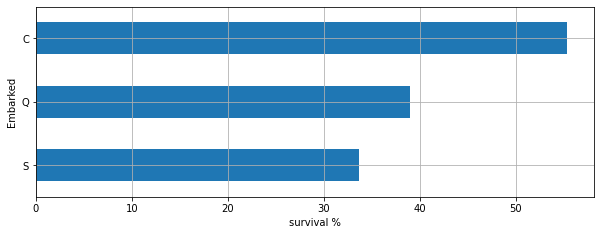

In [31]:
survival_rate_by_embarked = df.groupby(by='Embarked').sum()['Survived']*100/df.groupby(by='Embarked').count()['Survived']

plt.figure(figsize=(10,3.5))
survival_rate_by_embarked.sort_values(ascending=True).plot(kind='barh')
plt.grid(True)
plt.xlabel('survival %')
plt.ylabel('Embarked')

<AxesSubplot:xlabel='Cabin', ylabel='count'>

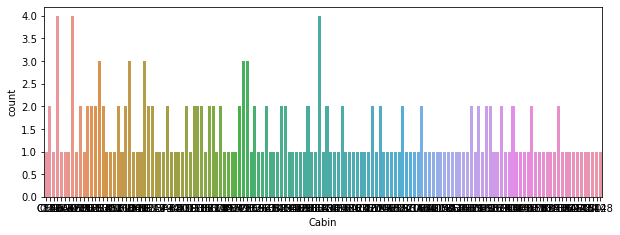

In [33]:
plt.figure(figsize=(10,3.5))
sns.countplot(data=df, x='Cabin')

This column contained significant null values. They'll be treated as an individual category. Well assess if we can find the possible reason why the cabin was not captured for those individuals.

The are also too many categories in this feature. We'll assess if the beginning letter to each cabin has any significance.

In [37]:
def return_cabin_lettr(cabin):
    if pd.isnull(cabin):
        return 'unknown'
    else:
        return cabin[0]
    
df['Cabin'] = df['Cabin'].apply(lambda x:return_cabin_lettr(x))

<AxesSubplot:xlabel='Cabin', ylabel='count'>

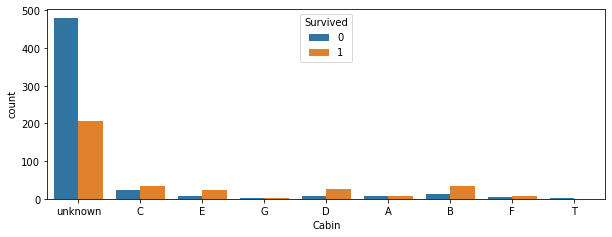

In [38]:
plt.figure(figsize=(10,3.5))
sns.countplot(data=df, x='Cabin', hue='Survived')

In [42]:
df['Cabin'].unique()

array(['unknown', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [45]:
'C' in df['Cabin'].unique()

True

Text(0, 0.5, 'cabin')

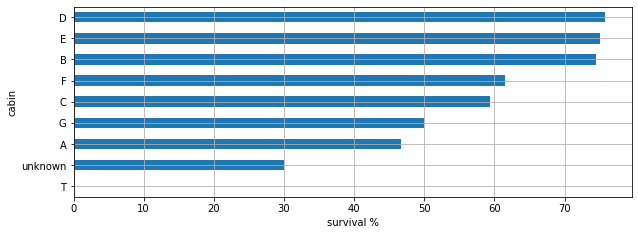

In [39]:
survival_rate_by_cabin = df.groupby(by='Cabin').sum()['Survived']*100/df.groupby(by='Cabin').count()['Survived']

plt.figure(figsize=(10,3.5))
survival_rate_by_cabin.sort_values(ascending=True).plot(kind='barh')
plt.grid(True)
plt.xlabel('survival %')
plt.ylabel('cabin')

**Setup Train and Test Data**

We will use the median Age to fill out the missing values. For Embarked, the 3 missing values will mean that 3 rows will be removed from the dataset. We will lastly drop columns Name and Ticket as their inclusion could potentially lead to more cluttering of our data.

We will use functions to ensure that we correctly adjust any new dataframe to the desired and consistent format.

In [102]:
def output_dataframe(new_df):
    df = pd.read_csv('train.csv')
    new_df['Age'].fillna(df['Age'].median(), inplace=True)
    new_df['Fare'].fillna(df['Fare'].median(), inplace=True)
    new_df['SibSp'] = np.log(new_df['SibSp']+1)
    new_df['Parch'] = np.log(new_df['Parch']+1)
    new_df['Fare'] = np.log(new_df['Fare']+1)
    new_df['Cabin'] = new_df['Cabin'].apply(lambda x:return_cabin_lettr(x))
    new_df.drop(['Name','Ticket'], axis=1, inplace=True)
    new_df.dropna(subset=['Embarked'],inplace=True)
    df_dummies = pd.get_dummies(new_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']])
    return df_dummies

This next function will ensure that all columns created in the train data, are present in the test data.

In [130]:
def df_columns(df_train, df_test):
    
    dataframe = pd.DataFrame(columns=df_train.columns)
    
    for col in df_train:
        if col in df_test.columns:
            dataframe[col] = df_test[col]
        else:
            dataframe[col] = 0
            
    return dataframe

In [118]:
df_dummies.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [52]:
df_dummies = output_dataframe(df)

In [53]:
df_dummies.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_unknown,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,0.693147,0.0,2.110213,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,1,38.0,0.693147,0.0,4.280593,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,26.0,0.000000,0.0,2.188856,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,35.0,0.693147,0.0,3.990834,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,3,35.0,0.000000,0.0,2.202765,0,1,0,0,0,0,0,0,0,0,1,0,0,1


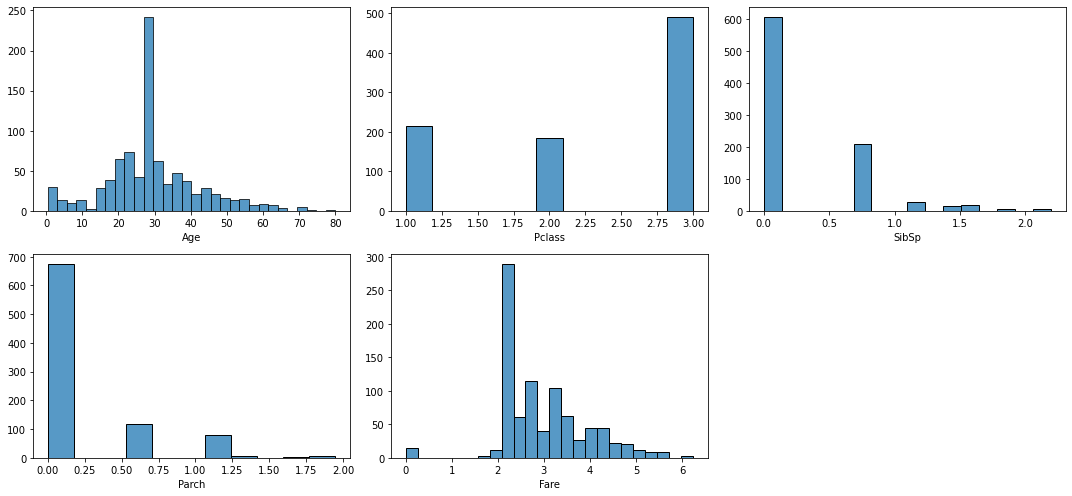

In [65]:
plt.figure(figsize=(15,7))
for i, col in enumerate(df_dummies[['Age','Pclass','SibSp','Parch','Fare']]):
  plt.subplot(2,3,i+1)
  sns.histplot(data=df_dummies, x=col)
  plt.ylabel('')
  plt.tight_layout()

In [54]:
X = df_dummies.values
y = df['Survived'].values

**Setup Train Test Split**

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

**Standardize features using Standard Scalar**

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [61]:
X_train[:,:5] = sc.fit_transform(X_train[:,:5])
X_test[:,:5] = sc.transform(X_test[:,:5])

**Train Machine Learning Models**

We will be training a Support Vector Machine and a Random Forest.

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

Support Vector Machine

In [78]:
svm = SVC(kernel = 'rbf', random_state = 0)
accuracies = cross_val_score(estimator = svm, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 83.18 %
Standard Deviation: 3.75 %


In [79]:
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = svm,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
best_clf_rf = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 83.63 %
Best Parameters: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}


In [90]:
svm = SVC(kernel = 'rbf', random_state = 0, C=0.5, gamma=0.1)
svm.fit(X_train, y_train)

SVC(C=0.5, gamma=0.1, random_state=0)

Random Forest

In [146]:
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf.fit(X_train, y_train)
accuracy = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracy.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracy.std()*100))

Accuracy: 80.02 %
Standard Deviation: 5.33 %


In [84]:
parameters =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
grid_search = RandomizedSearchCV(rf, param_distributions = parameters, n_iter = 100, cv = 10, verbose = True, n_jobs = -1)
best_clf_rf_rnd = grid_search.fit(X_train,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

**Make Predictions and Prepare Submissions**

In [132]:
k_test = output_dataframe(kaggle_test)
k_test = df_columns(df_dummies, k_test)
k_test.head()

In [136]:
k_X_test = k_test.values
k_X_test[:,:5] = sc.transform(k_X_test[:,:5])

Support Vector Machine Predictions

In [142]:
svm_pred = svm.predict(k_X_test)
svm_pred_df = pd.DataFrame({'PassengerId':kaggle_test['PassengerId'], 'Survived':svm_pred})
svm_pred_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [148]:
svm_pred_df.to_csv('submission_svm.csv', index =False)

Random Forest Predictions

In [147]:
rf_pred = rf.predict(k_X_test)
rf_pred_df = pd.DataFrame({'PassengerId':kaggle_test['PassengerId'], 'Survived':rf_pred})
rf_pred_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [149]:
rf_pred_df.to_csv('submission_rf.csv', index =False)